## Loading DataSet

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [41]:
# load the dataset
df = pd.read_excel("Tourism.xlsx",sheet_name='Tourism').drop(columns='CustomerID')
df.head(5)

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [25]:
# get dimension of the data
df.shape

(4888, 19)

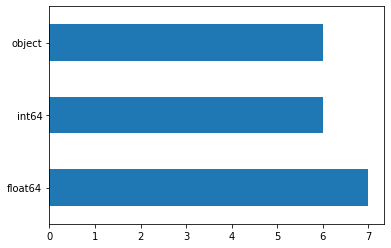

In [42]:
# count number of different data type
# there are 13 numeric and 6 categorical columns
df.dtypes.value_counts().plot(kind='barh');

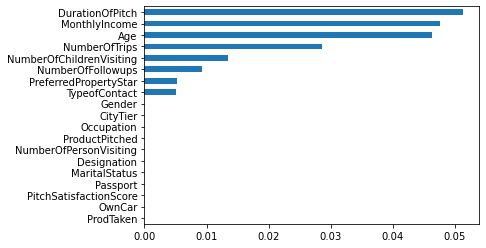

In [46]:
# check missing values
df.isna().mean().sort_values().plot(kind='barh');

## EDA

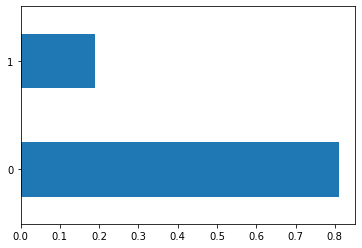

In [114]:
# distirbution of response variable. the data is highly imbalanced, number of 0 groups is significantly higher than 1 group
df['ProdTaken'].value_counts(normalize=True).plot(kind='barh');

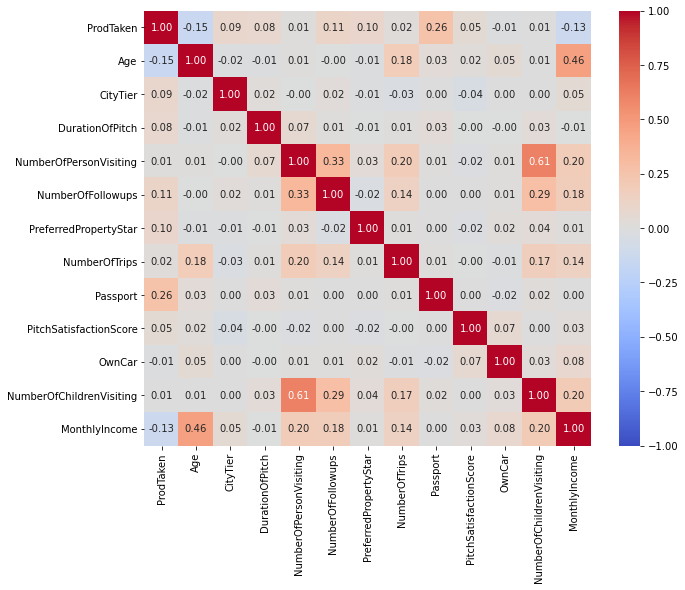

In [33]:
# correlation between variables
# response variable is correlation with Passport, age and income
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1);

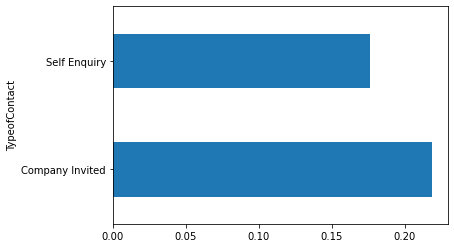

In [30]:
# the chance of accepting profuct is higher for those where invited by the company
# this could be due to the fact that many people are not aware of the product
df.groupby('TypeofContact')['ProdTaken'].mean().plot(kind='barh');

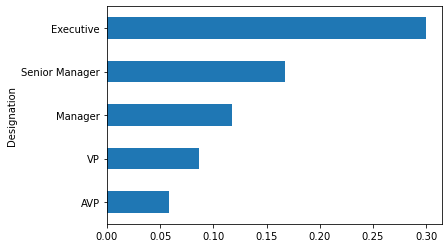

In [115]:
# percentage of accepting the product for different Designation, Exuctive has higher chance of accepting the product
df.groupby('Designation')['ProdTaken'].mean().sort_values().plot(kind='barh');

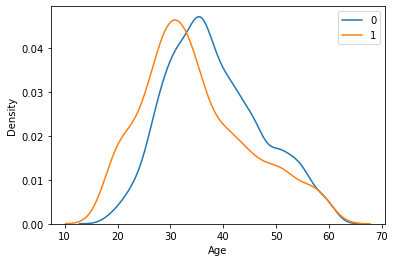

In [39]:
# distribution of age for two groups
# younger customer has higher rate of accepting the product
for name, rows in df.groupby('ProdTaken'):
    sns.kdeplot(rows['Age'], label=name)
plt.legend();

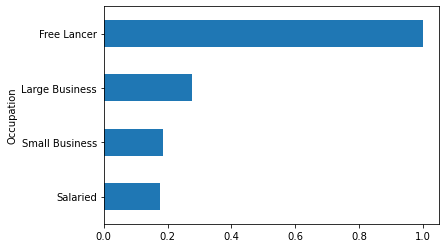

In [116]:
# chance of accepting the product for different occupation
df.groupby('Occupation')['ProdTaken'].mean().sort_values().plot(kind='barh');

## Modeling

In [71]:
# fill missing values
# categorical columns are replaced with the most common values
# numerical columns are replace with the column average
# there are some columns where missing means 0, such as number of followups (those who were self-enquiry had no followup)
df_clean = df.copy()
df_clean[['MonthlyIncome', 'Age', 'DurationOfPitch']] = df_clean[['MonthlyIncome', 'Age', 'DurationOfPitch']].apply(lambda x: x.fillna(x.mean()))
df_clean[['NumberOfTrips', 'NumberOfFollowups', 'NumberOfChildrenVisiting']] = df_clean[['NumberOfTrips', 'NumberOfFollowups', 'NumberOfChildrenVisiting']].fillna(0)
df_clean[['PreferredPropertyStar', 'TypeofContact']] = df_clean[['PreferredPropertyStar', 'TypeofContact']].apply(lambda x: x.fillna(x.mode()[0]))

In [78]:
# convert categorical column to dummy
df_dummy = pd.get_dummies(df_clean, drop_first=True)
kf = StratifiedKFold(n_splits=5, shuffle=True)

In [77]:
# seprarte features and response variables
X = df_dummy.drop(columns='ProdTaken')
y = df_dummy['ProdTaken']

In [88]:
# logisitic model
lr = LogisticRegression(max_iter=800)
y_lr = cross_val_predict(lr, X, y, cv=kf, groups=y, method='predict_proba')[:,1]
print('Logistic AUC: {:.3f}'.format(roc_auc_score(y, y_lr)))

Logistic AUC: 0.747


In [110]:
# decision tree model
tree = DecisionTreeClassifier(max_depth=8)
y_tree = cross_val_predict(tree, X, y, cv=kf, groups=y, method='predict_proba')[:,1]
print('Tree AUC: {:.3f}'.format(roc_auc_score(y, y_tree)))

Tree AUC: 0.827


In [117]:
# Random forest (bagging)
rf = RandomForestClassifier(n_estimators=50, max_depth=8)
y_rf = cross_val_predict(rf, X, y, cv=kf, groups=y, method='predict_proba')[:,1]
print('RF AUC: {:.3f}'.format(roc_auc_score(y, y_rf)))

RF AUC: 0.897


In [112]:
# xgboost (boosting)
xgb = XGBClassifier(n_estimators=50, max_depth=8, eval_metric ='logloss', use_label_encoder=False)
y_xgb = cross_val_predict(xgb, X.values, y.values.astype(int), cv=kf, groups=y, method='predict_proba')[:,1]
print('XGB AUC: {:.3f}'.format(roc_auc_score(y, y_xgb)))

XGB AUC: 0.970


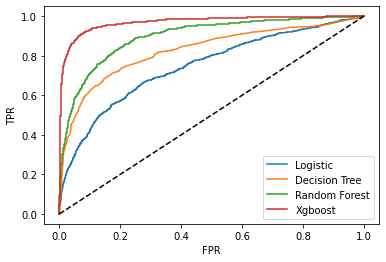

In [113]:
# plot ROC curve for different models
fpr, tpr, _ = roc_curve(y, y_lr)
plt.plot(fpr, tpr, label='Logistic')

fpr, tpr, _ = roc_curve(y, y_tree)
plt.plot(fpr, tpr, label='Decision Tree')

fpr, tpr, _ = roc_curve(y, y_rf)
plt.plot(fpr, tpr, label='Random Forest')

fpr, tpr, _ = roc_curve(y, y_xgb)
plt.plot(fpr, tpr, label='Xgboost')

plt.plot([0,1], [0,1],'k--');
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend();

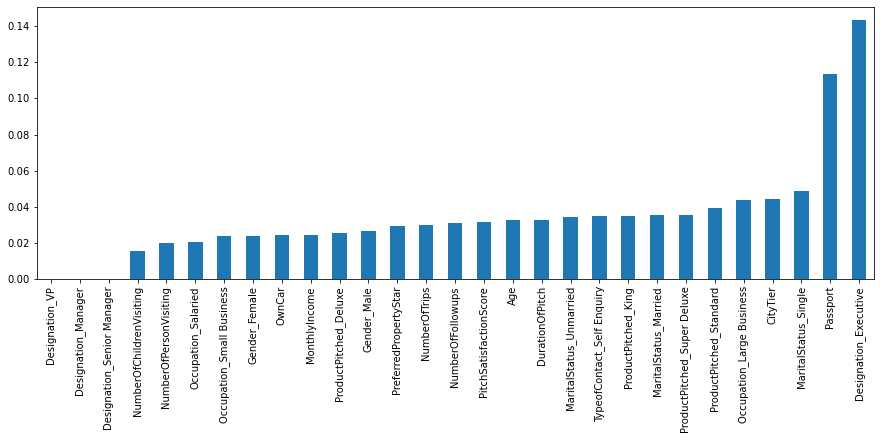

In [107]:
# feature importance of our best model
xgb.fit(X,y)
pd.Series(xgb.feature_importances_, index=X.columns).sort_values().plot(kind='bar', figsize=(15, 5));

## Conclusion

1. since the reponse variable is imbalaced, we used AUC score instead of accuracy. Accuracy is a good metric when the data is imbalanced
2. Performance of decision tree which is a nonlinear model is better than logisitc regression
3. performance of Random forest is better than decision tree since it is using a bagging technqiue and improve the genaralization of the model
4. Performance of xgboost which is a boosting model is better than random forest
5. Customer designation, having passport, and maritial status has major impact of customer decision to accept the product
6. In today's world Bagging helps with overfitting and variance.